# Cross-Cultural Breakout Films: Why Some Foreign Movies Go Global

**Question:**  
What makes some foreign movies become **worldwide hits**, while most remain popular only in their home countries?

**Why this is important:**  
- Helps us understand what kinds of stories and formats connect across cultures.  
- Shows how **distribution and genre choices** influence global success, not just movie quality.
- Can guide studios and streaming platforms when choosing international films to promote worldwide.

In [1]:
import os
import pandas as pd
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb

sns.set(style="whitegrid")

In [2]:
path = kagglehub.dataset_download("vivekananda99/imdb-dataset")
print("Dataset downloaded to:", path)

Dataset downloaded to: /kaggle/input/imdb-dataset


In [3]:
for root, dirs, files in os.walk(path):
    level = root.replace(path, "").count(os.sep)
    indent = " " * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    sub_indent = " " * 4 * (level + 1)
    for f in files:
        print(f"{sub_indent}{f}")

imdb-dataset/
    title.basics.tsv
    title.episode.tsv
    title.principals.tsv
    title.ratings.tsv
    name.basics.tsv
    title.akas.tsv
    title.crew.tsv


In [4]:
con = duckdb.connect(database=':memory:')


akas_path = os.path.join(path, "title.akas.tsv")
basics_path = os.path.join(path, "title.basics.tsv")
ratings_path = os.path.join(path, "title.ratings.tsv")

con.execute(f"""
    CREATE TABLE akas AS
    SELECT *
    FROM read_csv_auto('{akas_path}', delim='\t', nullstr='\\N');
""")

con.execute(f"""
    CREATE TABLE basics AS
    SELECT *
    FROM read_csv_auto('{basics_path}', delim='\t', nullstr='\\N');
""")

con.execute(f"""
    CREATE TABLE ratings AS
    SELECT *
    FROM read_csv_auto('{ratings_path}', delim='\t', nullstr='\\N');
""")

# Verify row counts
print("AKAS rows:", con.execute("SELECT COUNT(*) FROM akas").fetchone()[0])
print("BASICS rows:", con.execute("SELECT COUNT(*) FROM basics").fetchone()[0])
print("RATINGS rows:", con.execute("SELECT COUNT(*) FROM ratings").fetchone()[0])

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

AKAS rows: 53652907
BASICS rows: 12009132
RATINGS rows: 1629840


In [7]:
regions_df = con.execute("""
    SELECT region, COUNT(*) AS cnt
    FROM akas
    WHERE region IS NOT NULL
    GROUP BY region
    ORDER BY cnt DESC
    LIMIT 20
""").df()

print("Top Regions:")
display(regions_df)

languages_df = con.execute("""
    SELECT language, COUNT(*) AS cnt
    FROM akas
    WHERE language IS NOT NULL
    GROUP BY language
    ORDER BY cnt DESC
    LIMIT 20
""").df()

print("\nTop Languages:")
display(languages_df)


Top Regions:


,region,cnt
0,DE,5272837
1,JP,5253203
2,FR,5234133
3,IN,5189417
4,ES,5147351
5,IT,5123309
6,PT,5032493
7,US,1683513
8,GB,536750
9,CA,307426



Top Languages:


,language,cnt
0,ja,5096755
1,fr,5035899
2,hi,5001404
3,es,4978988
4,de,4965897
5,it,4963603
6,pt,4963429
7,en,629690
8,cmn,50671
9,ru,41238


In [8]:
con.execute("""
    CREATE TEMP TABLE akas_flags AS
    SELECT 
        titleId AS tconst,
        MAX(CASE WHEN region = 'US' THEN 1 ELSE 0 END) AS has_us_release,
        MAX(CASE WHEN language = 'en' THEN 1 ELSE 0 END) AS has_english_language,
        COUNT(DISTINCT region) AS region_count,
        COUNT(DISTINCT language) AS language_count
    FROM akas
    GROUP BY titleId;
""")

con.execute("""
    SELECT *
    FROM akas_flags
    LIMIT 10;
""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,tconst,has_us_release,has_english_language,region_count,language_count
0,tt0028028,0,1,18,4
1,tt0028037,1,0,3,0
2,tt0028178,1,0,4,1
3,tt0028299,1,1,4,2
4,tt0028318,1,0,5,0
5,tt0028348,1,0,2,0
6,tt0028454,0,1,2,2
7,tt0028478,1,1,21,3
8,tt0028657,1,0,3,0
9,tt0028708,1,1,20,5


In [9]:
con.execute("DROP TABLE IF EXISTS foreign_movies")

con.execute("""
    CREATE TEMP TABLE foreign_movies AS
    SELECT
        b.tconst,
        b.primaryTitle,
        b.startYear,
        b.runtimeMinutes,
        b.genres,
        f.region_count,
        f.language_count,
        r.numVotes,
        r.averageRating
    FROM basics b
    JOIN akas_flags f ON b.tconst = f.tconst
    JOIN ratings r ON b.tconst = r.tconst
    WHERE
        b.titleType = 'movie'
        AND f.has_us_release = 0
        AND f.has_english_language = 0
""")

print(
    "Foreign movies found:",
    con.execute("SELECT COUNT(*) FROM foreign_movies").fetchone()[0]
)

con.execute("""
    SELECT *
    FROM foreign_movies
    LIMIT 10
""").df()

Foreign movies found: 98006


,tconst,primaryTitle,startYear,runtimeMinutes,genres,region_count,language_count,numVotes,averageRating
0,tt9815124,Mami Jarum,2002,95,"Comedy,Drama",1,1,70,6.3
1,tt9813978,Exodus,2018,77,Documentary,1,0,29,6.4
2,tt0028274,Tredowata,1936,90,"Drama,Romance",2,0,110,6.3
3,tt0028861,Il feroce Saladino,1937,90,Comedy,3,1,31,6.4
4,tt0029095,Die Kronzeugin,1937,84,"Crime,Drama",5,3,10,7.0
5,tt0029323,Nuestro culpable,1938,87,"Comedy,Musical",1,0,31,6.6
6,tt0029815,Zauber der Boheme,1937,102,Drama,17,3,63,6.6
7,tt0029911,Bhabi,1938,<NA>,"Drama,Family",1,0,11,7.1
8,tt0030450,Mille lire al mese,1939,83,Comedy,5,0,19,5.0
9,tt0030505,Nirmala,1938,128,Drama,1,0,21,6.1


In [10]:
threshold = con.execute("""
    SELECT quantile_cont(numVotes, 0.9) 
    FROM foreign_movies
""").fetchone()[0]

print("Crossover vote threshold (Top 10% cut-off):", int(threshold))

Crossover vote threshold (Top 10% cut-off): 154


In [11]:
con.execute("DROP TABLE IF EXISTS foreign_labeled")

con.execute(f"""
    CREATE TEMP TABLE foreign_labeled AS
    SELECT *,
        CASE 
            WHEN numVotes >= {threshold} THEN 1 
            ELSE 0 
        END AS crossover_flag
    FROM foreign_movies
""")

con.execute("""
    SELECT crossover_flag, COUNT(*) AS count
    FROM foreign_labeled
    GROUP BY crossover_flag
    ORDER BY crossover_flag DESC
""").df()

,crossover_flag,count
0,1,9833
1,0,88173


In [12]:
con.execute("""
    SELECT 
        crossover_flag,
        AVG(region_count) AS avg_regions,
        AVG(language_count) AS avg_languages
    FROM foreign_labeled
    GROUP BY crossover_flag
    ORDER BY crossover_flag DESC
""").df()

,crossover_flag,avg_regions,avg_languages
0,1,3.038747,0.440862
1,0,1.555125,0.180600


In [13]:
con.execute("""
    SELECT 
        crossover_flag,
        AVG(runtimeMinutes) AS avg_runtime,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY runtimeMinutes) AS median_runtime
    FROM foreign_labeled
    WHERE runtimeMinutes IS NOT NULL
    GROUP BY crossover_flag
    ORDER BY crossover_flag DESC
""").df()

,crossover_flag,avg_runtime,median_runtime
0,1,100.252892,95.0
1,0,91.947239,90.0


In [14]:
con.execute("""
    SELECT 
        crossover_flag,
        AVG(averageRating) AS avg_rating,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY averageRating) AS median_rating
    FROM foreign_labeled
    GROUP BY crossover_flag
    ORDER BY crossover_flag DESC
""").df()

,crossover_flag,avg_rating,median_rating
0,1,5.867690,6.0
1,0,6.244762,6.3


In [15]:
con.execute("""
    SELECT 
        crossover_flag,
        AVG(
            array_length(string_split(genres, ','))
        ) AS avg_genre_count
    FROM foreign_labeled
    WHERE genres IS NOT NULL
    GROUP BY crossover_flag
    ORDER BY crossover_flag DESC
""").df()

,crossover_flag,avg_genre_count
0,1,1.787447
1,0,1.506809


In [16]:
con.execute("""
    CREATE TEMP TABLE genre_expanded AS
    SELECT
        crossover_flag,
        UNNEST(string_split(genres, ',')) AS genre
    FROM foreign_labeled
    WHERE genres IS NOT NULL
""")

print("Top genres in CROSSOVER films:")
display(con.execute("""
    SELECT genre, COUNT(*) AS cnt
    FROM genre_expanded
    WHERE crossover_flag = 1
    GROUP BY genre
    ORDER BY cnt DESC
    LIMIT 10
""").df())

print("Top genres in REGIONAL films:")
display(con.execute("""
    SELECT genre, COUNT(*) AS cnt
    FROM genre_expanded
    WHERE crossover_flag = 0
    GROUP BY genre
    ORDER BY cnt DESC
    LIMIT 10
""").df())

Top genres in CROSSOVER films:


,genre,cnt
0,Drama,4483
1,Comedy,4406
2,Romance,1357
3,Documentary,928
4,Crime,885
5,Action,877
6,Thriller,718
7,Family,544
8,Adventure,500
9,Horror,448


Top genres in REGIONAL films:


,genre,cnt
0,Drama,34792
1,Documentary,18943
2,Comedy,17902
3,Romance,7388
4,Action,6170
5,Crime,4726
6,Thriller,3988
7,Adventure,3854
8,Family,3399
9,Horror,3189


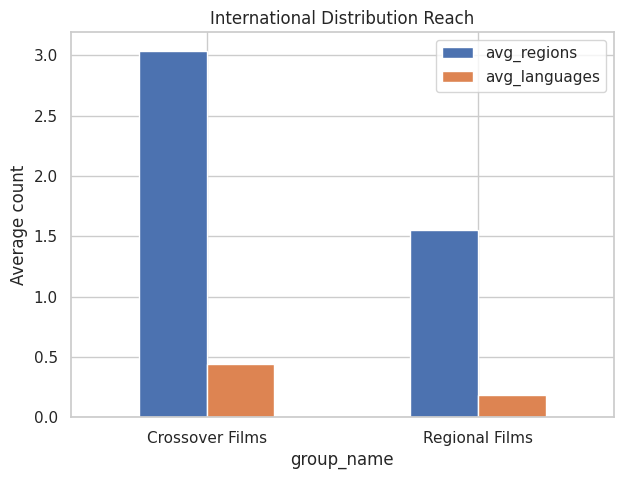

In [17]:

reach_df = con.execute("""
    SELECT 
        CASE WHEN crossover_flag = 1 THEN 'Crossover Films' ELSE 'Regional Films' END AS group_name,
        AVG(region_count) AS avg_regions,
        AVG(language_count) AS avg_languages
    FROM foreign_labeled
    GROUP BY crossover_flag
    ORDER BY crossover_flag DESC
""").df()

reach_df.set_index("group_name")[["avg_regions","avg_languages"]].plot(
    kind="bar",
    figsize=(7,5)
)

plt.title("International Distribution Reach")
plt.ylabel("Average count")
plt.xticks(rotation=0)
plt.show()

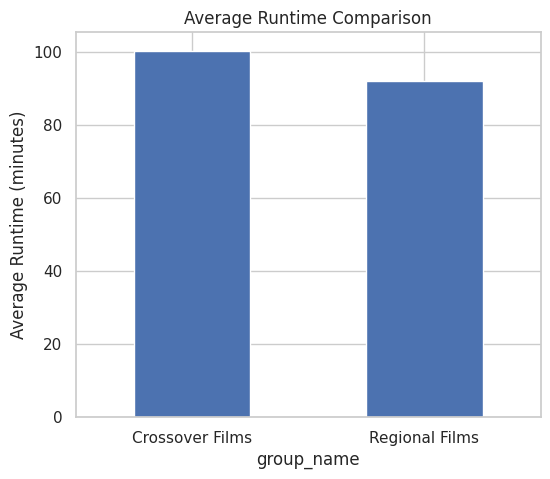

In [19]:
runtime_summary = con.execute("""
    SELECT 
        CASE WHEN crossover_flag = 1 THEN 'Crossover Films' ELSE 'Regional Films' END AS group_name,
        AVG(runtimeMinutes) AS avg_runtime
    FROM foreign_labeled
    WHERE runtimeMinutes IS NOT NULL
    GROUP BY crossover_flag
    ORDER BY crossover_flag DESC
""").df()

runtime_summary.set_index("group_name")["avg_runtime"].plot(
    kind="bar",
    figsize=(6,5)
)

plt.title("Average Runtime Comparison")
plt.ylabel("Average Runtime (minutes)")
plt.xticks(rotation=0)
plt.show()

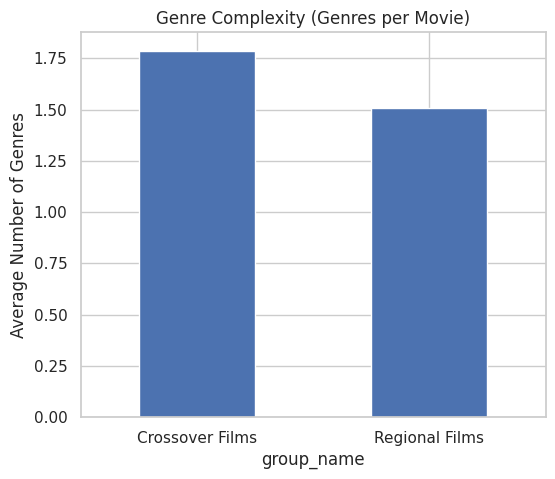

In [20]:
genre_complexity = con.execute("""
    SELECT 
        CASE WHEN crossover_flag = 1 THEN 'Crossover Films' ELSE 'Regional Films' END AS group_name,
        AVG(array_length(string_split(genres, ','))) AS avg_genre_count
    FROM foreign_labeled
    WHERE genres IS NOT NULL
    GROUP BY crossover_flag
    ORDER BY crossover_flag DESC
""").df()

genre_complexity.set_index("group_name")["avg_genre_count"].plot(
    kind="bar",
    figsize=(6,5)
)

plt.title("Genre Complexity (Genres per Movie)")
plt.ylabel("Average Number of Genres")
plt.xticks(rotation=0)
plt.show()

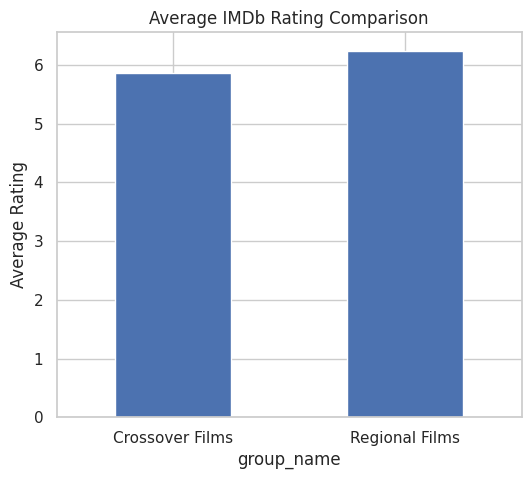

In [21]:
ratings_summary = con.execute("""
    SELECT 
        CASE WHEN crossover_flag = 1 THEN 'Crossover Films' ELSE 'Regional Films' END AS group_name,
        AVG(averageRating) AS avg_rating
    FROM foreign_labeled
    GROUP BY crossover_flag
    ORDER BY crossover_flag DESC
""").df()

ratings_summary.set_index("group_name")["avg_rating"].plot(
    kind="bar",
    figsize=(6,5)
)

plt.title("Average IMDb Rating Comparison")
plt.ylabel("Average Rating")
plt.xticks(rotation=0)
plt.show()

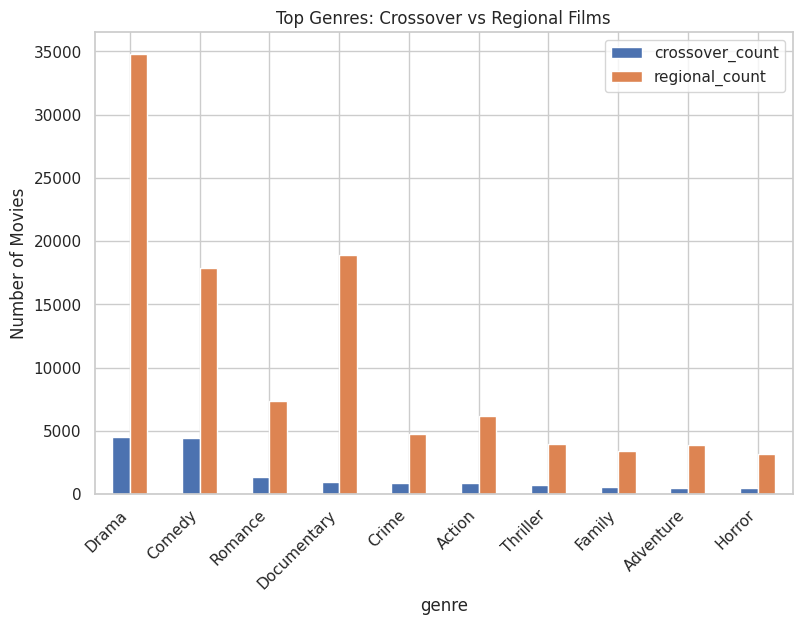

In [22]:
top_genres = con.execute("""
    SELECT genre, 
           SUM(CASE WHEN crossover_flag = 1 THEN 1 ELSE 0 END) AS crossover_count,
           SUM(CASE WHEN crossover_flag = 0 THEN 1 ELSE 0 END) AS regional_count
    FROM genre_expanded
    GROUP BY genre
    ORDER BY crossover_count DESC
    LIMIT 10
""").df()

top_genres.set_index("genre")[["crossover_count", "regional_count"]].plot(
    kind="bar",
    figsize=(9,6)
)

plt.title("Top Genres: Crossover vs Regional Films")
plt.ylabel("Number of Movies")
plt.xticks(rotation=45, ha="right")
plt.show()

## Key Insights — Why Some Foreign Movies Go Global

- **Going global is about where the movie is shown:**  
  Movies that become worldwide hits are released in **many more countries** and translated into **more languages**.  
  Regional movies usually stay limited to **just 1–2 locations**.

- **Global movies feel bigger:**  
  Breakout films are typically **a little longer**, allowing more space for story, emotion, and spectacle — they feel more like classic big-screen cinema.

- **Mixing styles helps reach everyone:**  
  Movies that travel globally often blend genres like **Action + Drama**, **Comedy + Romance**, or **Crime + Thriller**.  
  Single-genre films don’t reach as wide an audience.

- **Fun and excitement work everywhere:**  
  Genres such as **Comedy, Action, Thriller, Crime, and Adventure** dominate among global hits.  
  Movies that stay local are often **Documentaries or slow drama films**.

- **Popular doesn’t mean better:**  
  Surprisingly, regional films usually have **higher ratings**, meaning people like them more —  
  but far fewer people watch them.

- **Being seen matters more than being perfect:**  
  Small niche movies may be great, but **few people ever discover them**.  
  Breakout hits succeed because they are **easy to access and widely shown**, not because they get the best reviews.

---